In [48]:
import ccxt
# jupyter lab --NotebookApp.iopub_data_rate_limit=1.0e10 - this command is required to run when opening jupyter labs or ccxt wont work in jupyter. or configure a config file.
import pandas as pd
import hvplot.pandas
# from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import os
import sqlalchemy as sql
import sys
import numpy as np
from MCForecastTools import MCSimulation
from warnings import filterwarnings
import pandas_ta as ta
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
filterwarnings("ignore")

In [49]:
ALPACA_API_KEY = 'PK2BWJQC7W7Z3C87TKI6'
ALPACA_SECRET_KEY = 'qox7s7aZ70L9yAp8HS6Kz0JXngu6a20ikuD3EmCq'

In [50]:
# # Set the variables for the Alpaca API and secret keys
# alpaca_api_key=os.getenv(ALPACA_API_KEY)
# # Create the Alpaca tradeapi.REST object
# alpaca_secret_key=os.getenv(ALPACA_SECRET_KEY)



# # Set the variables for the Alpaca API and secret keys
# alpaca_api_key=os.getenv(ALPACA_API_KEY)
# # Create the Alpaca tradeapi.REST object
# alpaca_secret_key=os.getenv(ALPACA_SECRET_KEY)



alpaca=tradeapi.REST(ALPACA_API_KEY,ALPACA_SECRET_KEY,api_version="v2")


#Setting the tickers
tickers = ['SPY']

#Setting the timeframe
timeframe='1Day'

#Formatting the date
today = pd.Timestamp.now(tz="US/Pacific")
a_year_ago = pd.Timestamp(today - pd.Timedelta(days=1001)).isoformat()
end_date = pd.Timestamp(today - pd.Timedelta(days=1)).isoformat()

#Getting the closing prices
spy_price = alpaca.get_bars(
    tickers,
    timeframe,
    start=a_year_ago,
    end=end_date
).df

# Check for NaN Values
spy_price.isnull().dropna()

df_spy = spy_price.drop(columns=["trade_count","vwap","symbol"])
df_spy

,open,high,low,close,volume
timestamp,,,,,
2020-02-18 05:00:00+00:00,336.5100,337.6677,335.2100,336.73,57342526
2020-02-19 05:00:00+00:00,337.7900,339.0800,337.4800,338.32,48814692
2020-02-20 05:00:00+00:00,337.7423,338.6400,333.6817,336.99,74170362
2020-02-21 05:00:00+00:00,335.4700,335.8100,332.5800,333.45,113788208
2020-02-24 05:00:00+00:00,323.1400,333.5623,321.2400,322.42,161339718
...,...,...,...,...,...
2022-11-07 05:00:00+00:00,377.7100,380.5700,375.5300,379.95,68127819
2022-11-08 05:00:00+00:00,381.1100,385.1200,377.7200,382.00,84098301
2022-11-09 05:00:00+00:00,379.9300,381.1400,373.6100,374.13,77996412


In [51]:
database_name = 'sqlite:///'
# Database connection object
Engine = sql.create_engine(database_name)

In [5]:
def connect():
    '''Connect to the sqlite database server''' 
    conn = None
    try:
        # connect to the SQLite server
        print('Connecting to the SQLite database...')
        conn = sql.create_engine('sqlite:///')
    except :
        print("Connection not successful!")
        sys.exit(1)
    print("Connection Successful!")
    return conn
con = connect()

def copy_to_db(conn, df, table):
    """
    save the dataframe in memory as a sqlite database with name 'table' 
    conn is the connection engine used. use connect function to get 
    """    
    try:
        df.to_sql('%s'%table, con=conn, index=True,if_exists='replace')
        print(f'Saving dataframe as a table called {table} in sqlite database')
    except :
        print("Error")
    print("Done!")
    return conn.table_names()

copy_to_db(con,df_spy,table = 'spy_db_OHLCV')



def open_as_df(query,conn):
    '''pass query to get dataframe: select * from spy_db_OHLCV fx. '''
    try:
        df = pd.read_sql_query(sql = query,con = conn, index_col= ['timestamp'])
        print('Accessing SQLite database based on query')
    except :
        print('Error')
        sys.exit(1)
    return df

q= '''
SELECT timestamp, close
FROM 'spy_db_OHLCV'
'''
open_as_df(query=q, conn =con)

Connecting to the SQLite database...
Connection Successful!
Saving dataframe as a table called spy_db_OHLCV in sqlite database
Done!
Accessing SQLite database based on query


,close
timestamp,
2020-02-18 05:00:00.000000,336.73
2020-02-19 05:00:00.000000,338.32
2020-02-20 05:00:00.000000,336.99
2020-02-21 05:00:00.000000,333.45
2020-02-24 05:00:00.000000,322.42
...,...
2022-11-07 05:00:00.000000,379.95
2022-11-08 05:00:00.000000,382.00
2022-11-09 05:00:00.000000,374.13


In [6]:
# Create a table for the High Prices
SPY_high = df_spy['high']
SPY_high_df = pd.DataFrame(SPY_high)

# Create a SPY high prices table
SPY_high_df.to_sql('SPY_high',Engine, index=False,if_exists='replace')
Engine.table_names()

# Make a query to get the SPY volume prices
SPY_high_table = """
SELECT *
FROM SPY_high
"""

# Call the query 
spy_high_df = pd.read_sql_query(SPY_high_table, con=Engine)

# Plot the query for the SPY Prices
spy_high_df.hvplot(xlabel="Time Lenght",ylabel="High Prices",title="The High Prices for SPY")

# plot the summary statistics for the High prices
spy_high_df.describe()

,high
count,692.000000
mean,390.297434
std,55.591348
min,229.683300
25%,349.757500
50%,395.788850
75%,436.837500
max,479.980000


In [7]:
# Create a table for the High Prices
SPY_low = df_spy['low']
SPY_low_df = pd.DataFrame(SPY_low)

# Create a SPY high prices table
SPY_low_df.to_sql('SPY_low',Engine, index=False,if_exists='replace')
Engine.table_names()

# Make a query to get the SPY volume prices
SPY_low_table = """
SELECT *
FROM SPY_low
"""

# Call the query 
spy_low_df = pd.read_sql_query(SPY_low_table, con=Engine)

# Plot the query for the SPY Prices
spy_low_df.hvplot(xlabel="Time Lenght",ylabel="Low Prices",title="The Low Prices for SPY")

# plot the summary statistics for the Low prices
spy_low_df.describe()

,low
count,692.000000
mean,384.428102
std,56.408741
min,218.260000
25%,344.710000
50%,390.120000
75%,430.566350
max,476.060000


In [8]:
# Create a table for the High Prices
SPY_volume = df_spy['volume']
SPY_volume_df = pd.DataFrame(SPY_volume)

# Create a SPY high prices table
SPY_volume_df.to_sql('SPY_volume',Engine, index=False,if_exists='replace')
Engine.table_names()

# Make a query to get the SPY volume prices
SPY_volume_table = """
SELECT *
FROM SPY_volume
"""

# Call the query 
spy_volume_df = pd.read_sql_query(SPY_volume_table, con=Engine)

# Plot the query for the SPY Prices
SPY_volume_plot = spy_volume_df.hvplot(xlabel="Time Length",ylabel="Volume Prices",title="The Volume for SPY")
SPY_volume_plot

# plot the summary statistics for the Volume prices
spy_volume_df.describe()

,volume
count,6.920000e+02
mean,9.158184e+07
std,5.132590e+07
min,2.645785e+07
25%,5.909959e+07
50%,7.798934e+07
75%,1.059905e+08
max,4.269390e+08


In [9]:
# Create a Dataframe for the Close prices
SPY_close = df_spy["close"]
SPY_close.head()
SPY_close_df = pd.DataFrame(SPY_close)
SPY_close_df

# Create a SPY Close table
SPY_close_df.to_sql("SPY_Close",Engine,index=False,if_exists='replace')
Engine.table_names()

# Make a query to get the SPY 
SPY_Close_Table = """
SELECT *
FROM SPY_close
"""

# Call the query
df_spy_close_query = pd.read_sql_query(SPY_Close_Table, con=Engine)

# Plot the query for SPY Close prices
df_spy_close_query.hvplot(xlabel="Time Length",ylabel="Closing Prices",title="The Close Prices For the SPY")

# plot the summary statistics for the Close prices
df_spy[['close']].describe()

,close
count,692.000000
mean,387.521995
std,56.023140
min,222.680000
25%,347.485000
50%,392.640000
75%,434.452500
max,477.710000


In [10]:
# Getting connected to binanceus exchange, can change to any other exchange listed above. 
exchange_id = 'binanceus'
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'timeout':30000,
    'enableRateLimit':True,
})
exchange

# Load markets into variable
markets=exchange.load_markets()

# getting open high low close data for BTC from binance us, last 1000 hour candles. 
btc_ohlc = exchange.fetch_ohlcv('BTC/USD', timeframe='1d', limit=1000)

# Creating a dataframe
df_btc = pd.DataFrame(btc_ohlc,columns=['Timestamp','Open','High','Low','Close','Volume'])
df_btc

# Check for null values
df_btc.isnull().sum().dropna()

# taken unix to datetime from firas pandas extra demo code
def unix_to_date(unix):
    return pd.to_datetime(unix, unit = "ms").tz_localize('UTC').tz_convert('US/Pacific')

# Clean unix timestamp to a human readable timestamp. 
df_btc['Timestamp']= df_btc['Timestamp'].apply(unix_to_date)



df_btc = df_btc.set_index(['Timestamp'])
df_btc

,Open,High,Low,Close,Volume
Timestamp,,,,,
2020-02-18 16:00:00-08:00,10193.83,10300.00,9350.00,9599.72,518.047975
2020-02-19 16:00:00-08:00,9595.75,9706.64,9373.89,9607.08,294.300557
2020-02-20 16:00:00-08:00,9607.01,9773.04,9575.92,9697.35,192.053002
2020-02-21 16:00:00-08:00,9690.50,9723.12,9563.67,9671.67,144.023047
2020-02-22 16:00:00-08:00,9665.44,10028.50,9665.44,9975.71,230.655156
...,...,...,...,...,...
2022-11-09 16:00:00-08:00,15887.31,18154.76,15727.64,17553.93,16338.160482
2022-11-10 16:00:00-08:00,17555.02,17650.00,16330.17,17014.20,15261.900053
2022-11-11 16:00:00-08:00,17016.22,17071.83,16595.95,16781.45,5028.330594


In [11]:
# Get the database name 
database_name = 'sqlite:///'
# Get the Database connection object
Engine = sql.create_engine(database_name)


In [12]:
# Create a Dataframe for the Close prices
BTC_close = df_btc['Close']
BTC_close.head()
BTC_close_df = pd.DataFrame(BTC_close)
BTC_close_df

# Create a BTC Close table
BTC_close_df.to_sql("BTC_Close", Engine, index =False, if_exists='replace')


# Make a query to get the BTC Closing Prices
BTC_Close_Table = """
SELECT *
FROM BTC_Close
"""
# Call the query
df = pd.read_sql_query(BTC_Close_Table, con=Engine)

#Plot the query for BTC Close prices
df.hvplot(xlabel="Time Length", ylabel= "Closing Prices", title= "The Closing Prices for Bitcoin")

:Curve   [index]   (Close)

In [13]:
# plot the summary statistics for the Closing prices
BTC_close_df.describe()

,Close
count,1000.000000
mean,30439.787820
std,17089.224278
min,4891.930000
25%,13112.157500
50%,30276.185000
75%,44427.587500
max,67569.580000


In [14]:
# Create a table for the High prices
BTC_High = df_btc['High']
BTC_High_df = pd.DataFrame(BTC_High)

# Create a BTC High Prices table
BTC_High_df.to_sql("BTC_High", Engine, index =False, if_exists='replace')


# Make a query to get the BTC High Prices
BTC_High_Table = """
SELECT *
FROM BTC_High
"""
# Call the query
df = pd.read_sql_query(BTC_High_Table, con=Engine)

#Plot the query for BTC High prices
df.hvplot(xlabel="Time Length", ylabel= "High Prices", title= "The High Prices for BTC")



:Curve   [index]   (High)

In [15]:
# plot the summary statistics for the High prices
BTC_High_df.describe()

,High
count,1000.000000
mean,31272.350730
std,17564.957815
min,5345.270000
25%,13331.575000
50%,31359.385000
75%,45839.940000
max,69025.050000


In [16]:
# Create a Datafram for BTC Low Prices
BTC_Low = df_btc['Low']
BTC_Low_df = pd.DataFrame(BTC_Low)

# Create a table for BTC Low Prices
BTC_Low_df.to_sql("BTC_Low", Engine, index =True, if_exists='replace')

# Make a query to get the BTC Low Prices
BTC_Low_Table = """
SELECT *
FROM BTC_Low
"""
# Call the query
df = pd.read_sql_query(BTC_Low_Table, con=Engine, index_col = 'Timestamp')


#Plot the query for BTC Close prices
df.hvplot(xlabel="Time Length", ylabel= "High Prices", title= "The Low Prices for BTC")

:Curve   [Timestamp]   (Low)

In [17]:
# plot the summary statistics for the Low prices
BTC_Low_df.describe()

,Low
count,1000.000000
mean,29415.018820
std,16518.397207
min,3828.620000
25%,12856.645000
50%,29265.685000
75%,42866.880000
max,66251.040000


In [18]:
# Create a dataframe for the Volume 
BTC_Volume = df_btc['Volume']
BTC_Volume_df = pd.DataFrame(BTC_Volume)

# Create a table for the Volume 
BTC_Volume_df.to_sql("BTC_Volume", Engine, index =False, if_exists='replace')
Engine.table_names()

# Make a query to get the BTC Volume Prices
BTC_Volume_Table = """
SELECT *
FROM BTC_Volume
"""
# Call the query
df = pd.read_sql_query(BTC_Volume_Table, con=Engine)

#Plot the query for BTC Volume
BTC_volume_plot = df.hvplot(xlabel="Time Length", ylabel= "Volume", title= "The Volume for BTC")
BTC_volume_plot

:Curve   [index]   (Volume)

In [19]:
# plot the summary statistics for the Volume prices
BTC_Volume_df.describe()

,Volume
count,1000.000000
mean,2219.980381
std,3335.424903
min,103.741243
25%,590.747514
50%,1004.855385
75%,1941.962393
max,27123.992451


In [20]:
# plot the Volume for BTC and SPY next to each other
Volume_plots = BTC_volume_plot + SPY_volume_plot
Volume_plots

:Layout
   .Curve.I  :Curve   [index]   (Volume)
   .Curve.II :Curve   [index]   (volume)

In [21]:
# get the percent change for BTC and drop NaN values
# display the first 5 rows
btc_pct_change = BTC_close_df.pct_change().dropna()
btc_pct_change.head()

,Close
Timestamp,
2020-02-19 16:00:00-08:00,0.000767
2020-02-20 16:00:00-08:00,0.009396
2020-02-21 16:00:00-08:00,-0.002648
2020-02-22 16:00:00-08:00,0.031436
2020-02-23 16:00:00-08:00,-0.031628


In [22]:
# plot the pct change for btc
btc_pct_change_plot = btc_pct_change.hvplot(xlabel = 'Date', ylabel='Percent Change', title= 'The Percent Change for BTC')
btc_pct_change_plot

:Curve   [Timestamp]   (Close)

In [23]:
# get the percent change for SPY and drop NaN values
# display the first 5 rows
spy_pct_change = SPY_close_df.pct_change().dropna()
spy_pct_change.head()

,close
timestamp,
2020-02-19 05:00:00+00:00,0.004722
2020-02-20 05:00:00+00:00,-0.003931
2020-02-21 05:00:00+00:00,-0.010505
2020-02-24 05:00:00+00:00,-0.033078
2020-02-25 05:00:00+00:00,-0.030488


In [24]:
# plot the pct change for SPY
spy_pct_change_plot = spy_pct_change.hvplot(xlabel = 'Date', ylabel='Percent Change', title= 'The Percent Change for SPY')
spy_pct_change_plot 

:Curve   [timestamp]   (close)

In [25]:
# plot the cumulative returns for BTC
cum_returns_btc = (1 + btc_pct_change).cumprod() - 1 
plot_cum_returns_btc = cum_returns_btc.hvplot(xlabel = 'Date', ylabel='Percent Change', title= 'The Cumulative Percent Change for BTC')

# plot the cumulative returns for SPY
cum_returns_spy = (1 + spy_pct_change).cumprod() - 1 
plot_cum_returns_spy = cum_returns_spy.hvplot(xlabel = 'Date', ylabel='Percent Change', title= 'The Cumulative Percent Change for SPY')

#overlay the cumulative returns plot for BTC and SPY
btc_spy_cum_plot = plot_cum_returns_btc* plot_cum_returns_spy
btc_spy_cum_plot

:Overlay
   .Curve.I  :Curve   [Timestamp]   (Close)
   .Curve.II :Curve   [timestamp]   (close)

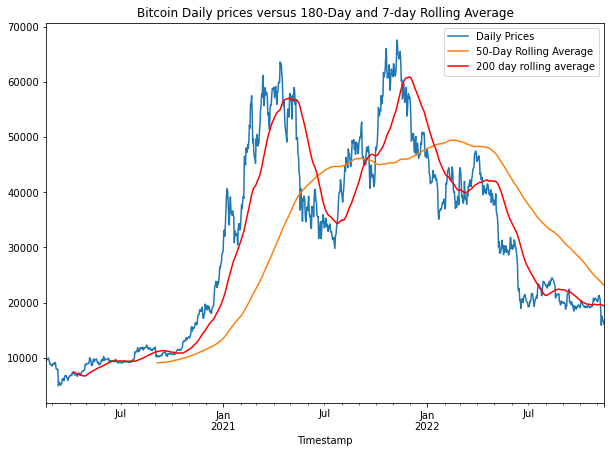

In [26]:
# btc_pct_change.rolling(window= 60).mean().plot()
# spy_pct_change.rolling(window= 60).mean().plot()
# ax = btc_annual_pct_change

ax = df_btc['Close'].plot(figsize=(10,7), title="Bitcoin Daily prices versus 180-Day and 7-day Rolling Average")
df_btc['Close'].rolling(window=200).mean().plot(ax=ax)
df_btc['Close'].rolling(window=50).mean().plot(ax=ax, color= 'red')
ax.legend(["Daily Prices", "50-Day Rolling Average", '200 day rolling average'])


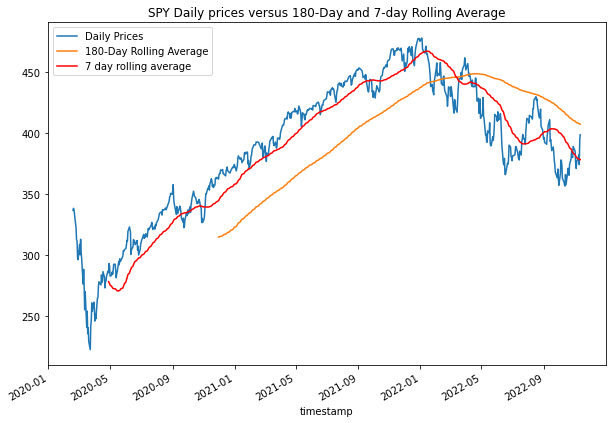

In [27]:
ax = df_spy['close'].plot(figsize=(10,7), title="SPY Daily prices versus 180-Day and 7-day Rolling Average")
df_spy['close'].rolling(window=200).mean().plot(ax=ax)
df_spy['close'].rolling(window=50).mean().plot(ax=ax, color= 'red')
ax.legend(["Daily Prices", "180-Day Rolling Average", '7 day rolling average'])

In [28]:
# calculate the annual return for btc
# Save this for deployment
btc_annual_pct_change = btc_pct_change.mean() * 365
btc_annual_pct_change

Close    0.486264
dtype: float64

In [29]:
# calculate the annual return for SPY
# Save this for deployment
spy_annual_pct_change = spy_pct_change.mean() * 252
spy_annual_pct_change

close    0.093275
dtype: float64

In [30]:
# calculate the annual std for BTC
# Save this for deployment
btc_annual_std = btc_pct_change.std() * (365) ** (1/2)
btc_annual_std

Close    0.761187
dtype: float64

In [31]:
# calculate the annual std for SPY
# Save this for deployment
spy_annual_std = spy_pct_change.std()*  (365) ** (1/2)
spy_annual_std

close    0.302889
dtype: float64

In [32]:
# calculate the sharpe ratio for BTC
# Save this for deployment
btc_sharpe_ratio = btc_annual_pct_change / btc_annual_std
btc_sharpe_ratio

Close    0.638823
dtype: float64

In [33]:
# calculate the sharpe ratio for SPY
# Save this for deployment
spy_sharpe_ratio = spy_annual_pct_change / spy_annual_std
spy_sharpe_ratio

close    0.30795
dtype: float64

In [34]:
# calculate the variance for SPY
# save this for deployment
spy_variance = spy_pct_change.var()
spy_variance

close    0.000251
dtype: float64

In [35]:
# calculate the variance for BTC
# save this for deployment
btc_variance = btc_pct_change.var()
btc_variance

Close    0.001587
dtype: float64

In [36]:
##### calculate the covariance from BTC to SPY
cov_btc_spy = btc_pct_change['Close'].cov(spy_pct_change['close'])
cov_btc_spy


nan

In [37]:
Name = pd.concat([btc_pct_change['Close'],spy_pct_change['close']], axis = 0, join = "inner")
Name_df = pd.DataFrame(Name)
Name_df

,0
2020-02-19 16:00:00-08:00,0.000767
2020-02-20 16:00:00-08:00,0.009396
2020-02-21 16:00:00-08:00,-0.002648
2020-02-22 16:00:00-08:00,0.031436
2020-02-23 16:00:00-08:00,-0.031628
...,...
2022-11-07 05:00:00+00:00,0.009566
2022-11-08 05:00:00+00:00,0.005395
2022-11-09 05:00:00+00:00,-0.020602
2022-11-10 05:00:00+00:00,0.054954


<AxesSubplot:xlabel='Timestamp'>

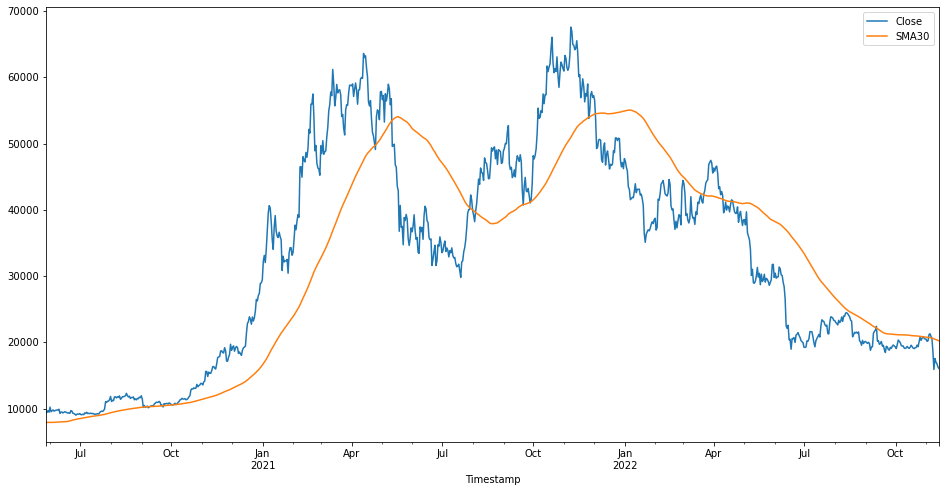

In [38]:
# Step 3: Calculating Simple Moving Average
# Updating our dataFrame to have only one column 'Close' as rest all columns are of no use for us at the moment
# using .to_frame() to convert pandas series into dataframe.
reliance = df_btc['Close'].to_frame()

# calculating simple moving average using .rolling(window).mean(), with window size = 30
reliance['SMA30'] = reliance['Close'].rolling(100).mean()

# Removing all the NULL values using dropna() method
reliance.dropna(inplace=True)

# Step 4: Plotting Simple Moving Averages

# Plotting Close price and simple moving average of 30 days using .plot() method
reliance[['Close', 'SMA30']].plot(label='RELIANCE',
figsize=(16, 8))

<AxesSubplot:xlabel='Timestamp'>

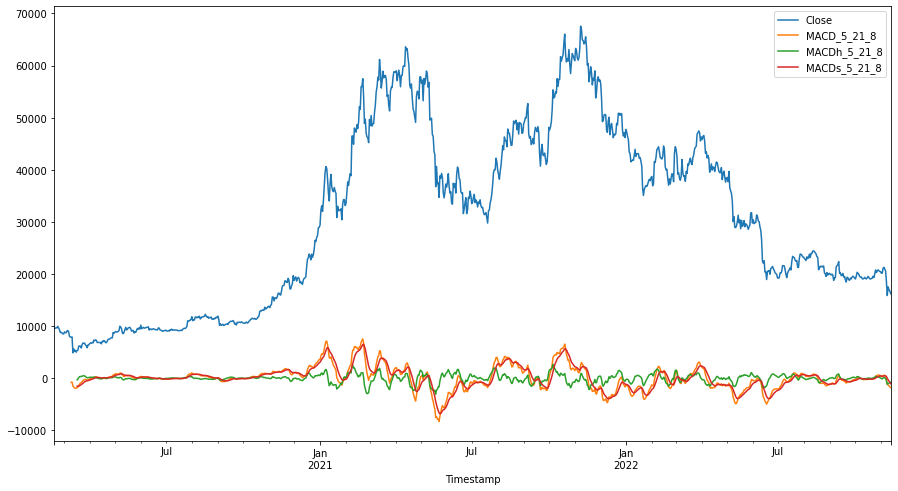

In [76]:
# Calculate MACD values using the pandas_ta library
BTC_close_df.ta.macd(close='close', fast=5, slow=21, signal=8, append=True)
# View result
pd.set_option("display.max_columns", None) 

# Create a MacD plot for BTC
df_btc_macd = pd.DataFrame(BTC_close_df)
df_btc_macd.plot(figsize=(15,8))


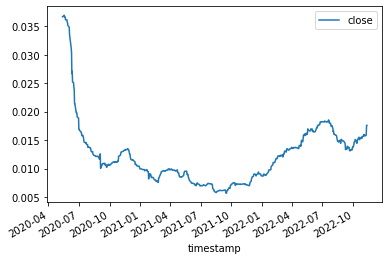

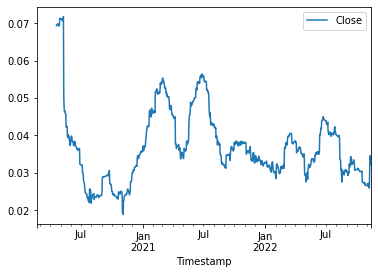

In [40]:
# plot the rolling std for spy and btc using a 60 day window
spy_rolling_std = spy_pct_change.rolling(window=60).std().plot()
btc_rolling_std = btc_pct_change.rolling(window=60).std().plot()

In [41]:

def get_data_crypto():
    # Getting connected to binanceus exchange, can change to any other exchange listed above. 
    exchange_id = 'binanceus'
    exchange_class = getattr(ccxt, exchange_id)
    exchange = exchange_class({
    'timeout':30000,
    'enableRateLimit':True,
    })
    # exchange
    # load market data
    markets=exchange.load_markets()
    # getting open high low close data for BTC from binance us, last 1000 hour candles. 
    btc_ohlc = exchange.fetch_ohlcv('BTC/USD', timeframe='1d', limit=691)
    # Creating a dataframe
    df_btc = pd.DataFrame(btc_ohlc,columns=['timestamp','Open','High','Low','Close','Volume'])
    # Check for null values
    df_btc.isnull().sum().dropna()

    # taken unix to datetime from firas pandas extra demo code
    def unix_to_date(unix):
        return pd.to_datetime(unix, unit = "ms").tz_localize('UTC').tz_convert('US/Pacific')

    # Clean unix timestamp to a human readable timestamp. 
    df_btc['timestamp']= df_btc['timestamp'].apply(unix_to_date)
    # set index as timestamp
    df_btc = df_btc.set_index(['timestamp'])
    return df_btc
    

get_data_crypto()



,Open,High,Low,Close,Volume
timestamp,,,,,
2020-12-23 16:00:00-08:00,23223.37,23780.20,22713.01,23718.85,700.058582
2020-12-24 16:00:00-08:00,23723.88,24773.31,23415.83,24707.15,847.083648
2020-12-25 16:00:00-08:00,24707.15,26848.13,24483.87,26466.72,947.022127
2020-12-26 16:00:00-08:00,26466.72,28383.51,25793.56,26247.11,1343.268909
2020-12-27 16:00:00-08:00,26250.00,27463.08,26076.60,27044.37,902.515385
...,...,...,...,...,...
2022-11-09 16:00:00-08:00,15887.31,18154.76,15727.64,17553.93,16338.160482
2022-11-10 16:00:00-08:00,17555.02,17650.00,16330.17,17014.20,15261.900053
2022-11-11 16:00:00-08:00,17016.22,17071.83,16595.95,16781.45,5028.330594


cagr (mean returns) :  0.2061
std_dev (standard deviation of return : ) 0.7612


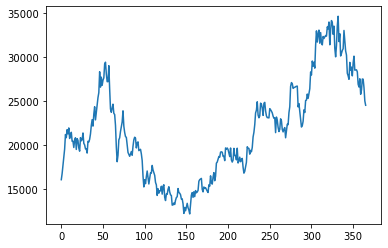

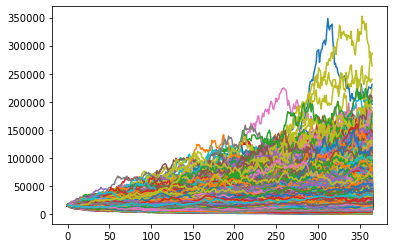

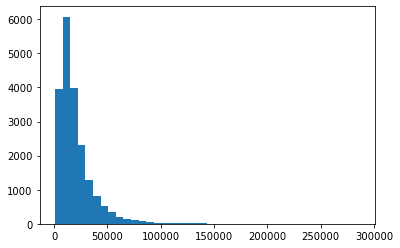

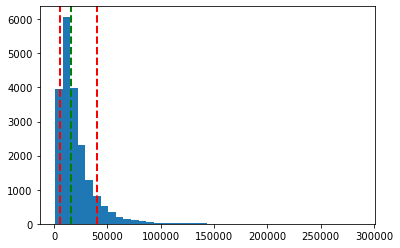

Expected price:  19826.09


In [73]:
time_elapsed = (df_btc.index[-1] - df_btc.index[0]).days

#Current price / first record (e.g. price at beginning of 2009)
#provides us with the total growth %
total_growth = (df_btc['Close'][-1] / df_btc['Close'][1])

#Next, we want to annualize this percentage
#First, we convert our time elapsed to the # of years elapsed
number_of_years = time_elapsed / 365.0
#Second, we can raise the total growth to the inverse of the # of years
#(e.g. ~1/10 at time of writing) to annualize our growth rate
cagr = total_growth ** (1/number_of_years) - 1

#Now that we have the mean annual growth rate above,
#we'll also need to calculate the standard deviation of the
#daily price changes
std_dev = df_btc['Close'].pct_change().std()

#Next, because there are roughy ~365 trading days in a year,
#we'll need to scale this by an annualization factor
#reference: https://www.fool.com/knowledge-center/how-to-calculate-annualized-volatility.aspx

number_of_trading_days = 365
std_dev = std_dev * math.sqrt(number_of_trading_days)

#From here, we have our two inputs needed to generate random
#values in our simulation
print ("cagr (mean returns) : ", str(round(cagr,4)))
print ("std_dev (standard deviation of return : )", str(round(std_dev,4)))

#Generate random values for 1 year's worth of trading (365 days),
#using numpy and assuming a normal distribution
daily_return_percentages = np.random.normal(cagr/number_of_trading_days, std_dev/math.sqrt(number_of_trading_days),number_of_trading_days)+1

#Now that we have created a random series of future
#daily return %s, we can simply apply these forward-looking
#to our last stock price in the window, effectively carrying forward
#a price prediction for the next year

#This distribution is known as a 'random walk'

price_series = [df_btc['Close'][-1]]

for j in daily_return_percentages:
    price_series.append(price_series[-1] * j)

#Great, now we can plot of single 'random walk' of stock prices
plt.plot(price_series)
plt.show()

#Now that we've created a single random walk above,
#we can simulate this process over a large sample size to
#get a better sense of the true expected distribution
number_of_trials = 20000

#set up an additional array to collect all possible
#closing prices in last day of window.
#We can toss this into a histogram
#to get a clearer sense of possible outcomes
closing_prices = []

for i in range(number_of_trials):
    #calculate randomized return percentages following our normal distribution
    #and using the mean / std dev we calculated above
    daily_return_percentages = np.random.normal(cagr/number_of_trading_days, std_dev/math.sqrt(number_of_trading_days),number_of_trading_days)+1
    price_series = [df_btc['Close'][-1]]

    for j in daily_return_percentages:
        #extrapolate price out for next year
        price_series.append(price_series[-1] * j)

    #append closing prices in last day of window for histogram
    closing_prices.append(price_series[-1])

    #plot all random walks
    plt.plot(price_series)

plt.show()

#plot histogram
plt.hist(closing_prices,bins=40)

plt.show()

#lastly, we can split the distribution into percentiles
#to help us gauge risk vs. reward

#Pull top 10% of possible outcomes
top_ten = np.percentile(closing_prices,100-10)

#Pull bottom 10% of possible outcomes
bottom_ten = np.percentile(closing_prices,10);

#create histogram again
plt.hist(closing_prices,bins=40)
#append w/ top 10% line
plt.axvline(top_ten,color='r',linestyle='dashed',linewidth=2)
#append w/ bottom 10% line
plt.axvline(bottom_ten,color='r',linestyle='dashed',linewidth=2)
#append with current price
plt.axvline(df_btc['Close'][-1],color='g', linestyle='dashed',linewidth=2)

plt.show()

#from here, we can check the mean of all ending prices
#allowing us to arrive at the most probable ending point
mean_end_price = round(np.mean(closing_prices),2)
print("Expected price: ", str(mean_end_price))

In [45]:
# Create the Alpaca API object
def get_data_qqq():
    alpaca = tradeapi.REST(
        ALPACA_API_KEY,
        ALPACA_SECRET_KEY,
        api_version="v2")

    # Format current date as ISO format 
    today = pd.Timestamp.now(tz="US/Pacific")
    a_year_ago = pd.Timestamp(today - pd.Timedelta(days=365)).isoformat()
    end_date = pd.Timestamp(today - pd.Timedelta(days=1)).isoformat()

    # Set the tickers
    tickers = ["QQQ"]


    # Set timeframe to one day ('1Day') for the Alpaca API
    timeframe = "1D"

    # Get current closing prices for NDX
    dqqq_price = alpaca.get_bars(
            tickers,
            timeframe,
            start=a_year_ago,
            end=end_date
        ).df

    # Display sample data
    # separate Ticker Data
    QQQ = dqqq_price[dqqq_price['symbol']=='QQQ'].drop('symbol', axis=1)
     
    # set the index as Timestamp
    # dqqq_price = dqqq_price.set_index(['Timestamp'])

    # Concatenate the Ticker DataFrames

    dqqq_price = pd.concat([QQQ],axis=1, keys=['QQQ'])
    return dqqq_price
    
get_data_qqq()

QQQ                                       \
                             open      high      low   close    volume   
timestamp                                                                
2021-11-15 05:00:00+00:00  395.91  396.2400  392.095  394.61  33652494   
2021-11-16 05:00:00+00:00  393.86  397.9300  393.660  397.42  27245683   
2021-11-17 05:00:00+00:00  397.75  399.7196  396.640  397.63  28679969   
2021-11-18 05:00:00+00:00  399.73  402.2700  397.450  401.75  45657700   
2021-11-19 05:00:00+00:00  403.43  405.3000  402.580  403.99  45139298   
...                           ...       ...      ...     ...       ...   
2022-11-07 05:00:00+00:00  265.75  268.1400  263.570  267.59  47633827   
2022-11-08 05:00:00+00:00  269.14  272.8500  265.520  269.54  63256464   
2022-11-09 05:00:00+00:00  267.76  268.5600  263.030  263.32  64924828   
2022-11-10 05:00:00+00:00  276.01  283.0500  273.850  282.75  99224808   
2022-11-11 05:00:00+00:00  282.56  288.6400  281.190  287.96  67408633   

                                                   
                          trade_count        vwap  
timestamp                                          
2021-11-15 05:00:00+00:00      305966  394.279193  
2021-11-16 05:00:00+00:00      241058  396.597850  
2021-11-17 05:00:00+00:00      230950  397.916646  
2021-11-18 05:00:00+00:00      324000  400.181462  
2021-11-19 05:00:00+00:00      282297  403.882112  
...                               ...         ...  
2022-11-07 05:00:00+00:00      324064  265.809716  
2022-11-08 05:00:00+00:00      394065  269.394645  
2022-11-09 05:00:00+00:00      444108  265.922487  
2022-11-10 05:00:00+00:00      700103  277.494636  
2022-11-11 05:00:00+00:00      446121  285.732714  

[251 rows x 7 columns]

In [ ]:

def get_data_spy():
    ALPACA_API_KEY = 'PK2BWJQC7W7Z3C87TKI6'
    ALPACA_SECRET_KEY = 'qox7s7aZ70L9yAp8HS6Kz0JXngu6a20ikuD3EmCq'
    
    # # Set the variables for the Alpaca API and secret keys
    # alpaca_api_key=os.getenv(ALPACA_API_KEY)
    # # Create the Alpaca tradeapi.REST object
    # alpaca_secret_key=os.getenv(ALPACA_SECRET_KEY)



    alpaca=tradeapi.REST(ALPACA_API_KEY,ALPACA_SECRET_KEY,api_version="v2")


    #Setting the tickers
    tickers = ['SPY']

    #Setting the timeframe
    timeframe='1Day'

    #Formatting the date
    today = pd.Timestamp.now(tz="US/Pacific")
    a_year_ago = pd.Timestamp(today - pd.Timedelta(days=15000)).isoformat()
    end_date = pd.Timestamp(today - pd.Timedelta(days=1)).isoformat()

    #Getting the closing prices
    spy_price = alpaca.get_bars(
    tickers,
    timeframe,
    start=a_year_ago,
    end=end_date
    ).df

    # Check for NaN Values
    spy_price.isnull().dropna()

    df_spy = spy_price.drop(columns=["trade_count","vwap","symbol"])
    return df_spy
    
get_data_spy()

In [ ]:
# 1. two dropdowns
# #   - pick symbol
#     - pick exchange

2. Run Monte Carlo Simulation

3. Print the results
 - standard deviation
 - Sharpe Ratio
 - Beta
 - Normal Distribution
 - 95% percent, mean return
 - Covariance/Variance, token compared directly to SPY
 - Range and Expected Week price

4.Do you want to save your results or run another simulation
 - save and email results back to user
 - exit and clear
